In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from resources import load_data, custom_k_fold_split
from tqdm import tqdm

def fit_and_evaluate_model(model, X, y):
    accuracy, precision, recall = [], [], []
    for fold in custom_k_fold_split(X, y, method='individual'):
        X_train, X_test, y_train, y_test = fold
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, predictions))
        precision.append(precision_score(y_test, predictions, average='weighted', zero_division=0))
        recall.append(recall_score(y_test, predictions, average='weighted'      , zero_division=0))
    return accuracy, precision, recall

def custom_resample(num_iterations, n_samples):
    sets = []
    for i in range(num_iterations):
        df = pd.read_csv('data/HR_data.csv', index_col=0)
        df.sample(n_samples, replace=True).reset_index().to_csv('data/HR_data_bootstrapped.csv')
        X, y = load_data('data/HR_data_bootstrapped.csv')
        sets.append((X, y))
    return sets

def bootstrap_evaluation(model, sets):
    bootstrap_results = {
        'accuracy': [],
        'precision':[],
        'recall': []
    }

    for X, y in tqdm(sets, desc=str(model).split('.')[-1].split("\'")[0]):
        model_ = model()
        accuracy, precision, recall = fit_and_evaluate_model(model_, X, y)
        bootstrap_results['accuracy'].append(accuracy)
        bootstrap_results['precision'].append(precision)
        bootstrap_results['recall'].append(recall)

    list_of_metrics = [[],[],[]]
    for i, metric in enumerate(bootstrap_results.keys()):            
        for round in bootstrap_results[metric]:
            for val in round:
                list_of_metrics[i].append(val)
    # returns accuracy, precision, recall
    return list_of_metrics

MLPClassifier: 100%|██████████| 5/5 [00:05<00:00,  1.18s/it]


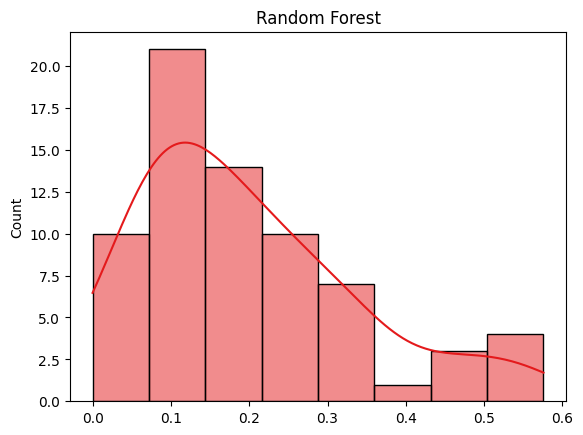

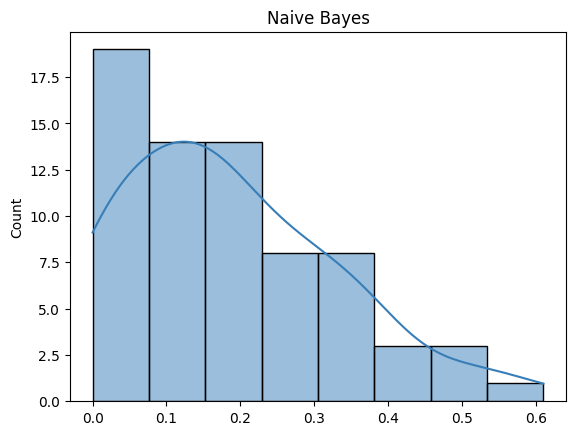

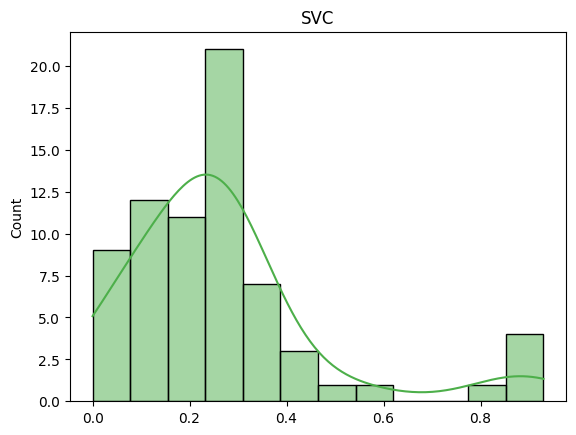

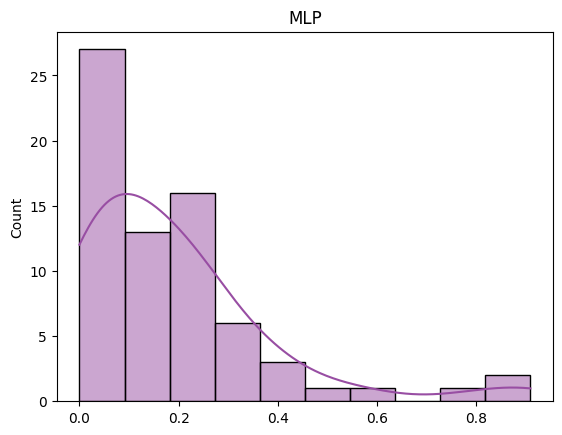

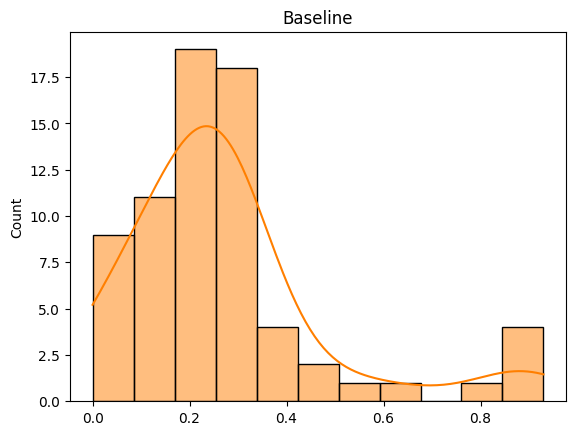

Random Forest Naive Bayes SVC MLP Baseline
0.1974747279640533 0.18660313439849915 0.2646741660924106 0.18827041363419053 0.2714796396064179
0.2637568544676777 0.22539650582707138 0.11848770087939474 0.08411197469514521 0.11730254573011363
0.1974747279640533 0.18660313439849915 0.2646741660924106 0.18827041363419053 0.2714796396064179


In [13]:
from models import Baseline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

data = custom_resample(5, 1000)

acc, precision, recall = bootstrap_evaluation(RandomForestClassifier, data)
base_acc, base_precision, base_recall = bootstrap_evaluation(Baseline, data)
nb_acc, nb_precision, nb_recall = bootstrap_evaluation(GaussianNB, data)
svc_acc, svc_precision, svc_recall = bootstrap_evaluation(SVC, data)
nn_acc, nn_precision, nn_recall = bootstrap_evaluation(MLPClassifier, data)
models = ['Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline']
accuracies = [acc, nb_acc, svc_acc, nn_acc, base_acc]

import seaborn as sns
import matplotlib.pyplot as plt

colors = sns.color_palette('Set1', n_colors=5)
for model, accuracy, color in zip(models, accuracies, colors):
    sns.histplot(accuracy, color=color, kde=True, label=model)
    plt.title(model)
    plt.show()

print('Random Forest', 'Naive Bayes', 'SVC', 'MLP','Baseline')
print(np.mean(acc), np.mean(nb_acc), np.mean(svc_acc), np.mean(nn_acc), np.mean(base_acc))
print(np.mean(precision), np.mean(nb_precision), np.mean(svc_precision), np.mean(nn_precision), np.mean(base_precision))
print(np.mean(recall), np.mean(nb_recall), np.mean(svc_recall), np.mean(nn_recall), np.mean(base_recall))

import pickle
for model, accuracies in zip(models, [acc, nb_acc, svc_acc, nn_acc, base_acc]):
    with open(f'metrics/{model}.pkl', 'wb') as f:
        pickle.dump(accuracies, f)